<a href="https://colab.research.google.com/github/Adheena-Ajayghosh/Assignments/blob/main/Assignment%2028.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 3 - Applying Bayes Classifiers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1TuDbIyso6irdyBFgaHRpC-PxUICWPHcS?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/tree/main/Bayesian/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

In [ ]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2023-10-16 12:25:21--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json’

arxiv-paper-data.js 100%[===================>]  69.07M   216MB/s    in 0.3s    

2023-10-16 12:25:22 (216 MB/s) - ‘arxiv-paper-data.json’ saved [72422946/72422946]



Let's make a few assumptions to come up with our first general model for classification:
* The different features contribute equally to the result
* The features are independent

## Bayes Classifiers in Scikit Learn

### Simple 1-D Classfication using Naive Bayes in Continuous Space

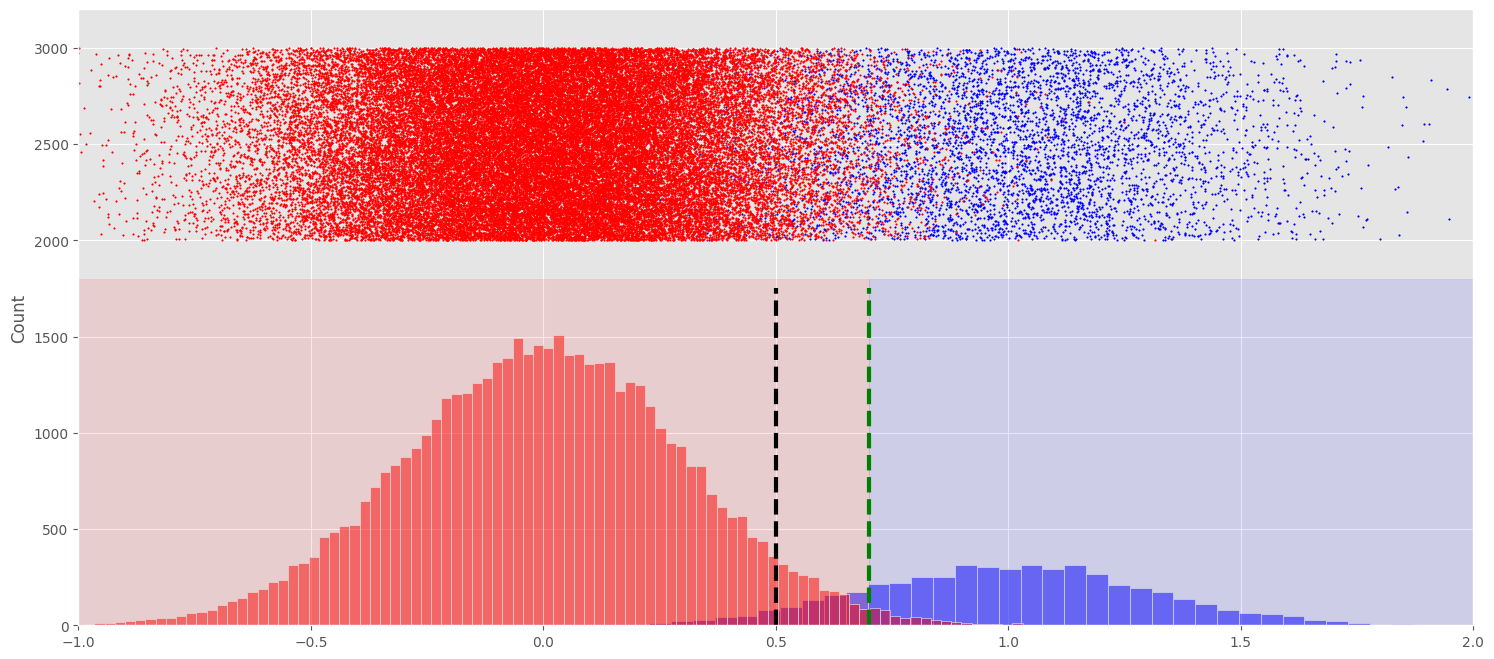

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


## Gaussian Bayes Predictor on Predicting Flowers

### Predictors in Scikit Learn

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

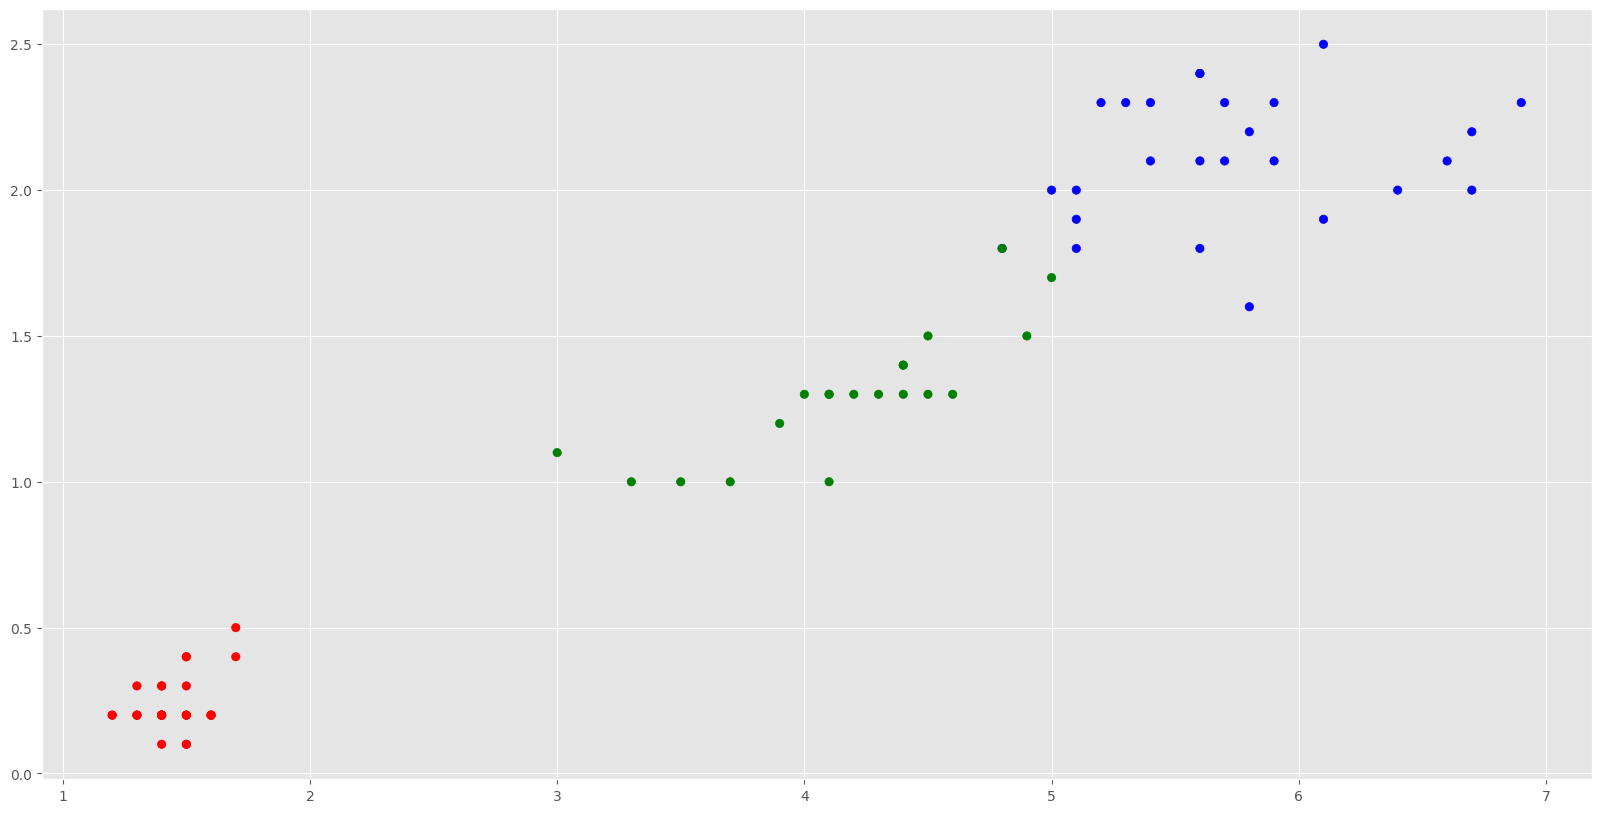

In [ ]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

### Visualizing the Decision Surface

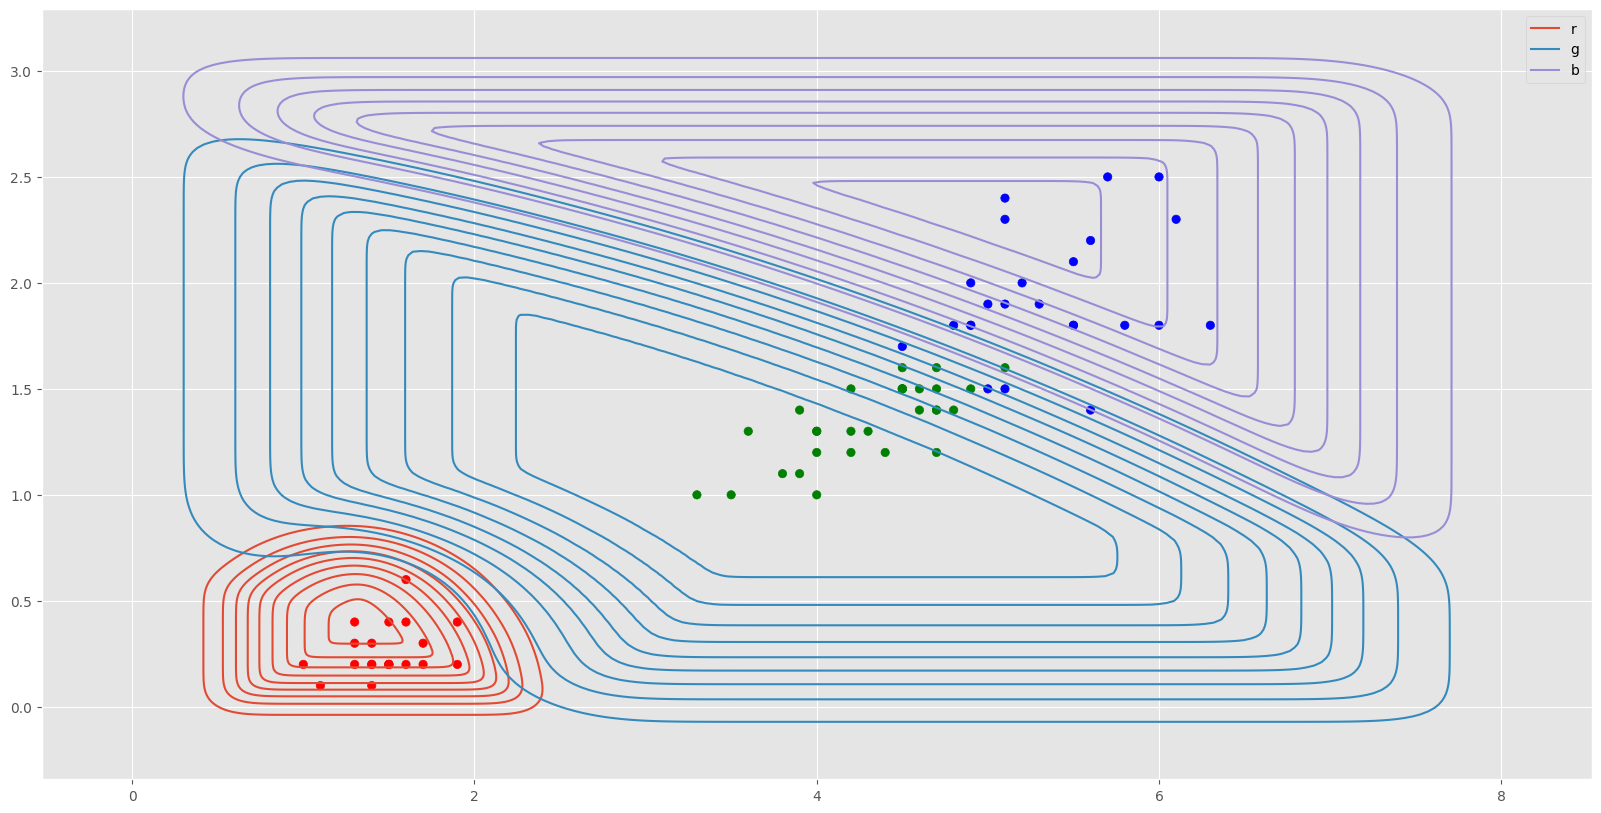

In [ ]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

## Bayes on Text - Classifying papers at Arxiv

### Data Cleaning and Preprocessing

In [ ]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [ ]:
SAMPLES_COMP = 3500 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 2500 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 1  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 8  #@param {type: "slider", min: 4, max: 20}

In [ ]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False),
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split()
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

train_df

,id,summary,tag,title,year,keywords
23487,1301.0612v1,This paper presents a novel method of foregrou...,cs,Adaptive Foreground and Shadow Detection inIma...,2012,"[foreground, segmentation, distinguishes, mono..."
6935,1707.07785v1,Relational probabilistic models have the chall...,stat,Comparing Aggregators for Relational Probabili...,2017,"[relational, probabilistic, challenge, aggrega..."
10878,1503.08535v1,Incorporating the side information of text cor...,stat,Infinite Author Topic Model based on Mixed Gam...,2015,"[incorporating, information, emotional, tradit..."
26307,1609.07986v3,A new resolution enhancement method is present...,cs,Super-resolving multiresolution images with ba...,2016,"[resolution, enhancement, presented, multispec..."
11112,1407.5158v2,"Based on a new atomic norm, we propose a new c...",stat,Tight convex relaxations for sparse matrix fac...,2014,"[formulation, factorization, formulation, clus..."
...,...,...,...,...,...,...
6032,1606.03672v1,"In this paper, we will investigate the efficac...",cs,Comparison of Several Sparse Recovery Methods ...,2016,"[investigate, recovering, compressed, applicat..."
14759,1204.0140v1,WordNet proved that it is possible to construc...,cs,Roget's Thesaurus as a Lexical Resource for Na...,2012,"[construct, electronic, principles, semantics,..."
12197,1710.04735v1,Ever growing volume and velocity of data coupl...,stat,On the Runtime-Efficacy Trade-off of Anomaly D...,2017,"[decreasing, attention, underscore, analytics,..."
5615,1309.6875v1,Conventional learning with expert advice metho...,cs,Active Learning with Expert Advice,2013,"[conventional, receiving, applications, acquir..."


In [ ]:
df['keywords']

23487    [foreground, segmentation, distinguishes, mono...
6935     [relational, probabilistic, challenge, aggrega...
10878    [incorporating, information, emotional, tradit...
26307    [resolution, enhancement, presented, multispec...
11112    [formulation, factorization, formulation, clus...
                               ...                        
14315    [estimating, clustering, structures, establish...
1341     [architectures, renaissance, convolutional, di...
17849    [wikipedia, languages, distributed, investigat...
37915    [posterior, distribution, predictive, distribu...
10959    [applications, uncertainty, forecasts, uncerta...
Name: keywords, Length: 6000, dtype: object

### Learning Probability Distributions

In [ ]:
from collections import defaultdict
dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]),
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 8856 words.
Out of those 4507 have over 1 occurances


For each word, for both the subjects, we can apply Bayes rule.

$$P\bigg(\frac{\text{subject}}{\text{word}}\bigg) = P\bigg(\frac{\text{word}}{\text{subject}}\bigg) \times \frac{P(\text{subject})}{P(\text{word})}$$

### Computing the resultant probabilities

In [ ]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (4507,), (4507, 2))

In [ ]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7891666666666667


### Visualizing a few examples

In [ ]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [ ]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [ ]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [ ]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [ ]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

### Visualizing the Learnt Words

In [ ]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	knowledge (0.11735595616825734)
	representation (0.1247790738776953)
	architecture (0.08589607635206786)
	segmentation (0.07104984093319194)
	experimental (0.13503004595263343)
	information (0.25203252032520324)
	detection (0.12513255567338283)
	different (0.2718275008837045)
	convolutional (0.127960410038883)
	recognition (0.13856486390950867)

Some Statistics words are:
	variables (0.13901572805682394)
	estimation (0.17148655504819887)
	stochastic (0.14510400811770674)
	statistical (0.15728056823947234)
	theoretical (0.15220700152207)
	distribution (0.18518518518518517)
	inference (0.20142059868087264)
	algorithm (0.4018264840182648)
	dimensional (0.19431760527650938)
	regression (0.19533231861998984)


## Probability Smoothing

Probability smoothing is a language modeling technique that assigns some non-zero probability to events that were unseen in the training data. This has the effect that the probability mass is divided over more events, hence the probability distribution becomes more smooth.

### Realizing the Problem

In [ ]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]),
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [ ]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	misspecification
	recidivism
	semiparametric
	subdomains
	methylation
	misspecified
	economists
	couplings
	perturbative
	thresholded
	wirtinger
	asymmetries
	robustify
	censoring
	deterioration
	parametrically
	cheminformatics
	varepsilon
	centrality
	assimilation
Some words which never appear in Statistics papers:
	monocular
	grammatically
	syntactical
	succession
	transcriptions
	singularities
	transcribing
	extraordinary
	timescale
	surpasses
	satisfiability
	enhancements
	predicates
	upsampling
	acquisitions
	susceptibility
	perfusion
	intravascular
	retinopathy
	hypertree


Notice the fact that there are cases where the Evidence $P\big(\frac{\text{word}}{\text{subject}}\big) \rightarrow 0$. This is because there are occurances of the given word in the corpus (all the abstract of papers put together) of that subject.

However, this is no way implies that if a word (eg. Employment) never occurs in our training corpus in a Computer Science paper, it will also never occur in a paper in the test set.

Therefore, setting $P(\text{word} | \text{subject}) = 0$ is incorrect, since it will make the posterior $P(\text{subject} | \text{word}) = 0$, even if the corresponding count it 0, we need to come up with a smoother formulation of the Evidence variables.

### Laplace Smoothing



https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece


3.0490593651858406e-05


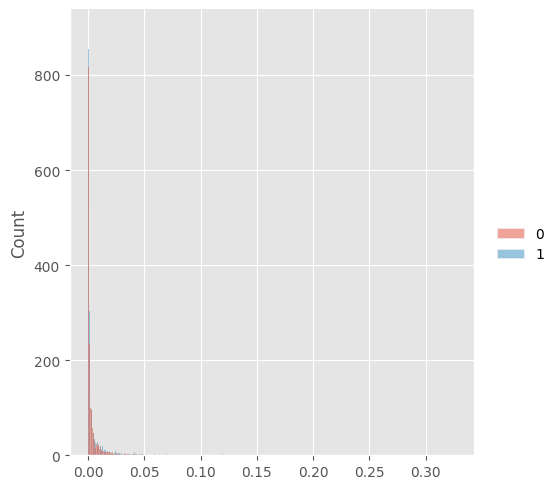

In [ ]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [ ]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7491666666666666


# **Questions**

1. In the "Bayes on Text - Classifying papers at Arxiv" section, what preprocessing steps are performed on the Arxiv paper data? Why are these steps necessary?

2. How are probability distributions learned from the Arxiv paper data, and how are these distributions used in the classification of papers into Computer Science (CS) and Statistics (Stat) categories?

3. What is probability smoothing, and why is it necessary in the context of the Bayesian classifier used in this code? How does Laplace smoothing improve the model's performance, and what parameter is involved in Laplace smoothing?

4. The code uses Laplace smoothing with a fixed value of alpha = 0.1. How might you experiment with different values of alpha to observe the impact on classification accuracy? Provide an example of how you would modify the code to test various alpha values.

5. In the "Visualizing the Decision Surface" section, the code visualizes the decision boundary for the Gaussian Naive Bayes classifier. How would you adjust the code to change the size or color of the decision boundary line, and what significance might these changes have?

#Solutions

#1

Steps:
Tokenization: Tokenization is the process of breaking the text into individual words or tokens.

Text Cleaning: This step involves removing any irrelevant or noisy data.

Lowercasing: Converting all text to lowercase helps ensure that the model treats words with different cases (e.g., "apple" and "Apple") as the same word.

Stop Word Removal: Removing stop words (e.g., "the," "and," "is") can reduce noise and improve the model's ability to focus on meaningful words.

Stemming or Lemmatization: Stemming and lemmatization are techniques used to reduce words to their base or root form.

Feature Engineering: Depending on the specific classification task, additional features might be engineered from the text data.

Text Vectorization: Text data needs to be converted into a numerical format for machine learning models.

Data Splitting: The data is typically split into training, validation, and test sets to train and evaluate the machine learning model. This ensures that the model's performance is assessed on unseen data.


#2

The probability distributions are used to quantify the model's confidence in its predictions. By examining the probability scores, you can assess how confident the model is in its classification decision. For instance, if a paper has a high probability of being in the CS category, the model is more certain about its classification.

Ultimately, this process leverages machine learning models to automatically categorize ArXiv papers into Computer Science and Statistics categories based on their textual content, and the learned probability distributions play a key role in this classification process.






#3

Probability smoothing is a technique used in the context of Bayesian classifiers, including Naive Bayes, to address issues related to zero probabilities or sparse data. It's necessary to prevent the model from making overly confident and incorrect predictions based on limited training data. In the context of Bayesian classification, probability smoothing helps to improve the model's robustness and generalization performance.

One common form of probability smoothing is Laplace smoothing .Laplace smoothing involves adding a small constant (typically 1) to the count of each feature (word) in each class, as well as a constant that represents the number of unique features. This modification ensures that no feature has a zero probability in any class.

How Laplace Smoothing Improves Performance:

Laplace smoothing ensures that no feature has a zero probability in any class, which allows the model to make predictions even if certain features were not observed during training.

Laplace smoothing also addresses the issue of imbalanced classes. It ensures that each class has non-zero probabilities for all features.

The additional constant term acts as a form of regularization, preventing the model from becoming too overconfident and making excessively sharp decisions.





#4

3.534254899723116e-08
3.479386375418831e-06
0.00013631406761177754


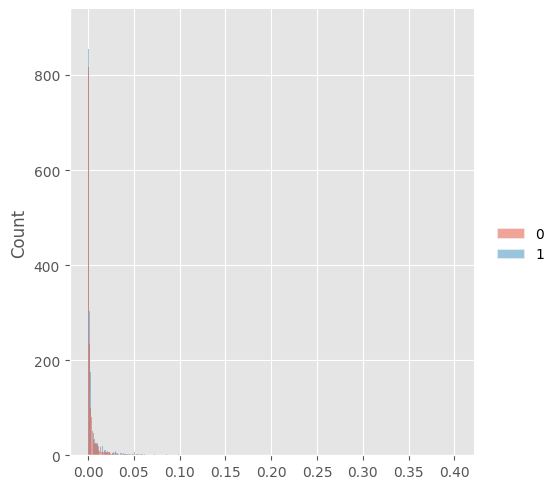

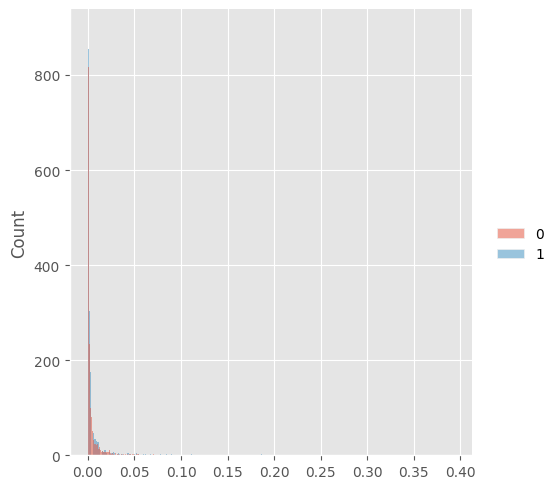

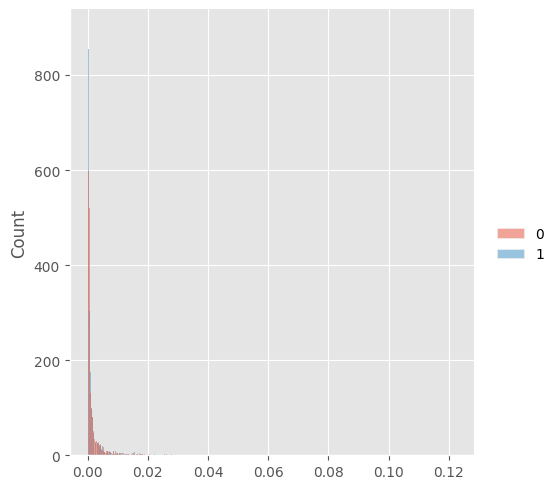

In [ ]:
alphas = [0.0001, 0.01, 1.0]

for alpha in alphas:
  counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
  evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                              (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
  print(np.min(evidence_smooth))
  sns.displot(evidence_smooth)

In [ ]:
alphas = [0.0001, 0.01, 1.0]

accuracy_results = {}

for alpha in alphas:
    counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
    evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                                (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T

    correct, total = 0, 0
    answers = []

    for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
        this_counts = np.zeros(len(words))
        for word in keywords:
            idx = words_to_index[word]
            if idx != -1:
                this_counts[idx] = 1

        marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
        joint = np.sum(np.log(marginal), axis=0)
        predicted = 'cs' if joint[0] > joint[1] else 'stat'
        answers.append(predicted)

        if predicted == tag:
            correct += 1
        total += 1

    accuracy = correct / total

    accuracy_results[alpha] = accuracy

    print(f"Alpha = {alpha}: Accuracy = {accuracy}")

Alpha = 0.0001: Accuracy = 0.7941666666666667
Alpha = 0.01: Accuracy = 0.7833333333333333
Alpha = 1.0: Accuracy = 0.63


#5

In the "Visualizing the Decision Surface" section, the code visualizes the decision boundary for the Gaussian Naive Bayes classifier. If you want to adjust the size or color of the decision boundary line, you can do so by modifying the parameters of the contourf function in the code. The contourf function is typically used to create filled contour plots for visualizing decision boundaries

Modifying the size and color of the decision boundary line can impact the readability and visual appeal of your classification boundary plot. The specific changes you make should align with your visualization objectives and preferences.